# H&M Personalized Fashion Recommendations: 3. Implicit 

In [5]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

from scipy.sparse import csr_matrix, coo_matrix

import implicit
from implicit.evaluation import mean_average_precision_at_k

from tqdm.notebook import tqdm

import logging
logging.basicConfig(level=logging.INFO)
logging.info("test")

import sys
sys.path.append("..")
from src.utils import *

SEED = 1

INFO:root:test


## 1. Download data 

In [2]:
articles = pd.read_csv("../input/articles_proc.csv", dtype={"article_id": str})
customers = pd.read_csv("../input/customers_proc.csv")
transactions_full = pd.read_csv("../input/transactions_full.csv", dtype={"article_id": str})
transactions_train = pd.read_csv("../input/transactions_train.csv", dtype={"article_id": str})
transactions_test = pd.read_csv("../input/transactions_test.csv", dtype={"article_id": str})
sample_subm = pd.read_csv("../input/sample_submission.csv")

transactions_full["rating"] = 1
transactions_train["rating"] = 1
transactions_test["rating"] = 1

test_min_date = "2020-09-15"
k = 12
full_data_shape = (customers.shape[0], articles.shape[0])

## 2. Get true articles 

In [7]:
true_articles = get_true_articles(transactions_test)
true_articles

customer_id
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318                                           0794321007
00039306476aaf41a07fed942884f16b30abfa83a2a8bea972019098d6406793                                           0624486001
0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55                                           0827487003
00040239317e877c77ac6e79df42eb2633ad38fcac09fc0094e549180ddc201c                                0875272011 0875272012
000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9                     0757926001 0788575004 0640021019
                                                                                          ...                        
fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82bd11d746ddb223dff26                                0874816003 0911870004
fffa7d7799eb390a76308454cbdd76e473d65b1497fbe44fe8cf95effea0bed7                                0861803014 0849886010
fffae8eb3a282d8c43c77dd2ca0621703b71e90904df

## 3. Make dataset 

In [17]:
class DatasetMaker:
    def __init__(self, 
                 train_data,  
                 min_date: str = None, 
                 max_date: str = None):
        if (min_date is not None) and (max_date is not None):
            self.train_data = train_data[train_data["t_dat"].between(min_date, max_date)]
        elif min_date is not None:
            self.train_datatrain_data = train_data[train_data["t_dat"] >= min_date]
        elif max_date is not None:
            self.train_data = train_data[train_data["t_dat"] < max_date]
        else:
            self.train_data = train_data
        
        self.articles_num2id = dict(enumerate(train_data["article_id"].unique()))
        self.articles_id2num = {id_: num for num, id_  in self.articles_num2id.items()}

        self.customers_num2id = dict(enumerate(train_data["customer_id"].unique()))
        self.customers_id2num = {id_: num for num, id_ in self.customers_num2id.items()}
        
    def get_csr_matrix(self, data = None):
        if data is None:
            data = self.train_data
        data_csr = csr_matrix(
            (
                data["rating"], 
                (
                    data["customer_id"].map(self.customers_id2num), 
                    data["article_id"].map(self.articles_id2num)
                )
            ),
            shape=(
                max(self.customers_num2id.keys()) + 1, 
                max(self.articles_num2id.keys()) + 1
            ),
            dtype=np.uint8
        )
        return data_csr
    
dm = DatasetMaker(
    train_data=transactions_train,
    min_date=subtract_days(test_min_date, days=30*2), 
    max_date=test_min_date
)
train = dm.get_csr_matrix()
val = dm.get_csr_matrix(transactions_test)

ValueError: negative row index found

## 6. Prediction 

In [66]:
def get_prediction(model, 
                   train,
                   customers_num2id, 
                   articles_num2id,
                   true_articles,
                   k: int = 12,
                   items: list = None, 
                   disable_tqdm=False):
    pred_customer_list = []
    pred_articles_list = []
    for customer_num in tqdm(range(train.shape[0]), disable=disable_tqdm):
        article_list, score_list = model.recommend(
            customer_num, 
            train[customer_num], 
            N=k,                                
            items=items
        )
        
        pred_customer_list.append(customers_num2id[customer_num])
        pred_articles_list.append(" ".join(list(map(lambda x: articles_num2id[x], article_list))))

    predict_df = (
        pd.DataFrame(
            data={"customer_id": pred_customer_list, 
                  "prediction": pred_articles_list
                 }
        )
            .merge(pd.DataFrame(true_articles).reset_index(), on="customer_id", how="inner")
            .rename({"article_id": "actual"}, axis=1)
    )
    return predict_df

## 6. Models

In [122]:
from collections import defaultdict

month_list = defaultdict(list)
factors_list = defaultdict(list)
regularization_list = defaultdict(list)
lr_list = defaultdict(list)
map_list = defaultdict(list)

In [124]:
for month_diff in [1, 2, 3, 6, 12]:
    dm = DatasetMaker(
        train_data=transactions_train,
        min_date=subtract_days(test_min_date, days=30 * month_diff), 
        max_date=test_min_date
    )
    train = dm.get_csr_matrix()
    
    
    for factors in [1, 50, 100, 150, 200]:
            als = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                       iterations=1000,
                                                       use_gpu=True,  
                                                       num_threads=16,
                                                       calculate_training_loss=True, 
                                                       use_native=False, 
                                                       random_state=SEED)
            als.fit(train, show_progress=True)

            prediction = get_prediction(
                model=als, 
                train=train, 
                customers_num2id=dm.customers_num2id,
                articles_num2id=dm.articles_num2id,
                true_articles=true_articles,
                k=12,
            )

            map_score = map_at_k(prediction["actual"], prediction["prediction"])

            print(month_diff, factors, round(map_score, 4))

            month_list["als"].append(month_diff)
            factors_list["als"].append(factors)
            map_list["als"].append(map_score)

INFO:implicit:Final training loss -0.0008



1 1 0.0043


INFO:implicit:Final training loss -0.0008



1 50 0.01


INFO:implicit:Final training loss -0.0007



1 100 0.011


INFO:implicit:Final training loss -0.0007



1 150 0.0111


INFO:implicit:Final training loss -0.0007



1 200 0.0105


INFO:implicit:Final training loss 0.0013



2 1 0.0033


INFO:implicit:Final training loss 0.0012



2 50 0.0077


INFO:implicit:Final training loss 0.0012



2 100 0.0085


INFO:implicit:Final training loss 0.0011



2 150 0.0083


INFO:implicit:Final training loss 0.0011



2 200 0.0085


INFO:implicit:Final training loss 0.0029



3 1 0.0026


INFO:implicit:Final training loss 0.0027



3 50 0.0053


INFO:implicit:Final training loss 0.0026



3 100 0.0058


INFO:implicit:Final training loss 0.0026



3 150 0.0059


INFO:implicit:Final training loss 0.0025



3 200 0.006


INFO:implicit:Final training loss -0.0068



6 1 0.0013


INFO:implicit:Final training loss -0.0064



6 50 0.0036


INFO:implicit:Final training loss -0.0062



6 100 0.0036


INFO:implicit:Final training loss -0.0061



6 150 0.0038


INFO:implicit:Final training loss -0.0059



6 200 0.0039


INFO:implicit:Final training loss 0.0236



12 1 0.0026


INFO:implicit:Final training loss 0.0225



12 50 0.0046


INFO:implicit:Final training loss 0.0219



12 100 0.0044


INFO:implicit:Final training loss 0.0215



12 150 0.0041


INFO:implicit:Final training loss 0.0211



12 200 0.0037


In [125]:
for month_diff in [1, 2, 3, 6, 12]:
    dm = DatasetMaker(
        train_data=transactions_train,
        min_date=subtract_days(test_min_date, days=30 * month_diff), 
        max_date=test_min_date
    )
    train = dm.get_csr_matrix()
    
    
    for factors in [1, 50, 100, 150, 200]:
            bpr = implicit.bpr.BayesianPersonalizedRanking(factors=factors, 
                                                           iterations=1000,
                                                           use_gpu=True, 
                                                           num_threads=16,
                                                           random_state=SEED)
            bpr.fit(train, show_progress=True)

            prediction = get_prediction(
                model=bpr, 
                train=train, 
                customers_num2id=dm.customers_num2id,
                articles_num2id=dm.articles_num2id,
                true_articles=true_articles,
                k=12,
            )

            map_score = map_at_k(prediction["actual"], prediction["prediction"])

            print(month_diff, factors, map_score)

            month_list["bpr"].append(month_diff)
            factors_list["bpr"].append(factors)
            map_list["bpr"].append(map_score)


1 1 3.312620394618563e-05



1 50 0.007605703423469256



1 100 0.009411751638815871



1 150 0.009915844331240563



1 200 0.009963750510919049



2 1 4.336332710140533e-05



2 50 0.00619002129230956



2 100 0.007170217446613214



2 150 0.0077819114112982314



2 200 0.008055337755338992



3 1 2.289542966170212e-05



3 50 0.004407973035115896



3 100 0.005437831571618108



3 150 0.005927641715621578



3 200 0.006343148344495955



6 1 1.9666874028707785e-05



6 50 0.003241732325562256



6 100 0.004034439489819853



6 150 0.004435695297569954



6 200 0.004755330936564047



12 1 1.913422155109485e-05



12 50 0.0024083381377493157



12 100 0.003114477241403602



12 150 0.0034226925412788466



12 200 0.003667620143119012


In [144]:
for month_diff in [1, 2, 3, 6, 12]:
    dm = DatasetMaker(
        train_data=transactions_train,
        min_date=subtract_days(test_min_date, days=30 * month_diff), 
        max_date=test_min_date
    )
    train = dm.get_csr_matrix()
    
    
    for factors in [1, 10, 30, 50]:
                lmf = implicit.lmf.LogisticMatrixFactorization(factors=factors, 
                                                               iterations=1000, 
                                                               learning_rate=10,
                                                               regularization=0.6,
                                                               neg_prop=30,
                                                               num_threads=16)
                lmf.fit(train, show_progress=True)

                prediction = get_prediction(
                    model=lmf, 
                    train=train, 
                    customers_num2id=dm.customers_num2id,
                    articles_num2id=dm.articles_num2id,
                    true_articles=true_articles,
                    k=12,
                )

                map_score = map_at_k(prediction["actual"], prediction["prediction"])

                print(month_diff, factors, map_score)

                month_list["lmf"].append(month_diff)
                factors_list["lmf"].append(factors)
                map_list["lmf"].append(map_score)


1 1 0.004334427326653555



1 10 0.004087871274880961



1 30 0.003773742974628726



1 50 0.004366478295147414



2 1 0.003551737788662733



2 10 0.0032854333972665017



2 30 0.0029971426421966513



2 50 0.0030716815662706976



3 1 0.0024205716428466893



3 10 0.0024909503365245288



3 30 0.002076321235739644



3 50 0.002347469511544178



6 1 0.0019012090782841752



6 10 0.0019561068736352475



6 30 0.0012169893210350427



6 50 0.001843865385029776



12 1 0.001989016924009597



12 10 0.0017169508931210034



12 30 0.0011525647940458278



12 50 0.0016833713163039309


In [158]:
def get_popular_articles(transactions, k)-> list:
    return transactions["article_id"].value_counts().index.to_list()[:k]
get_popular_articles(transactions_train, k)

['0706016001',
 '0706016002',
 '0372860001',
 '0610776002',
 '0759871002',
 '0464297007',
 '0372860002',
 '0610776001',
 '0399223001',
 '0720125001',
 '0706016003',
 '0156231001']

In [170]:
for month_diff in [1, 2, 3, 6, 12]:
    dm = DatasetMaker(
        train_data=transactions_train,
        min_date=subtract_days(test_min_date, days=30 * month_diff), 
        max_date=test_min_date
    )
    train = dm.get_csr_matrix()
    
    prediction = [get_popular_articles(dm.train_data, k)] * train.shape[0]

    map_score = map_at_k(true_articles, prediction)

    print(month_diff, map_score)

    month_list["popular"].append(month_diff)
    map_list["popular"].append(map_score)

1 0.005493015568953696
2 0.004705887762602287
3 0.0036109906589614628
6 0.00249037307499036
12 0.002945263474216827


In [175]:
data = defaultdict(list)
for model in month_list:
    for i in range(len(month_list[model])):
        data["month"].append(month_list[model][i])
        if model in factors_list:
            data["factors"].append(factors_list[model][i])
        else: 
            data["factors"].append("None")
        data["map"].append(map_list[model][i])
        data["model"].append(model)

IndexError: list index out of range

In [156]:
pd.DataFrame(data).groupby(["model", "month"])["map"].max().reset_index()

,model,month,map
0,als,1,0.011078
1,als,2,0.008513
2,als,3,0.006036
3,als,6,0.003938
4,als,12,0.004590
5,bpr,1,0.009964
6,bpr,2,0.008055
7,bpr,3,0.006343
8,bpr,6,0.004755
9,bpr,12,0.003668


<AxesSubplot:xlabel='month', ylabel='map'>

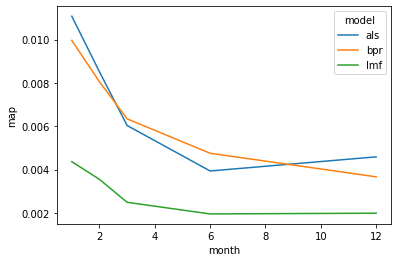

In [157]:
sns.lineplot(data=pd.DataFrame(data).groupby(["model", "month"])["map"].max().reset_index(), 
             x="month", y="map", hue="model")

## Предсказания 

In [180]:
def get_prediction(model, 
                   train,
                   customers_num2id, 
                   articles_num2id,
#                    true_articles,
                   k: int = 12,
                   items: list = None, 
                   disable_tqdm=False):
    pred_customer_list = []
    pred_articles_list = []
    for customer_num in tqdm(range(train.shape[0]), disable=disable_tqdm):
        article_list, score_list = model.recommend(
            customer_num, 
            train[customer_num], 
            N=k,                                
            items=items
        )
        
        pred_customer_list.append(customers_num2id[customer_num])
        pred_articles_list.append(" ".join(list(map(lambda x: articles_num2id[x], article_list))))

    predict_df = (
        pd.DataFrame(
            data={"customer_id": pred_customer_list, 
                  "prediction": pred_articles_list
                 }
        )
#             .merge(pd.DataFrame(true_articles).reset_index(), on="customer_id", how="inner")
#             .rename({"article_id": "actual"}, axis=1)
    )
    return predict_df

In [191]:
dm = DatasetMaker(
    train_data=transactions_train,
#     min_date=subtract_days(test_min_date, days=30 * 1), 
#     max_date=test_min_date
)
train = dm.get_csr_matrix()

als = implicit.als.AlternatingLeastSquares(factors=150, 
                                           iterations=1000,
                                           use_gpu=True,  
                                           num_threads=16,
                                           calculate_training_loss=True, 
                                           use_native=False, 
                                           random_state=SEED)
als.fit(train, show_progress=True)

prediction = get_prediction(
    model=als, 
    train=train, 
    customers_num2id=dm.customers_num2id,
    articles_num2id=dm.articles_num2id,
#     true_articles=true_articles,
    k=12,
)

# map_score = map_at_k(prediction["actual"], prediction["prediction"])

INFO:implicit:Final training loss -0.0298


In [192]:
prediction

,customer_id,prediction
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0609719001 0458543001 0838055001 0351484027 05...
1,00007d2de826758b65a93dd24ce629ed66842531df6699...,0160442043 0723469001 0615141002 0373506001 03...
2,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0600886011 0571706001 0589599001 0699075001 06...
3,0008968c0d451dbc5a9968da03196fe20051965edde741...,0778064003 0655784001 0751664001 0772902001 07...
4,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,0758088002 0758089002 0758040001 0758043001 07...
...,...,...
1356127,ff7e18c399dbab282c2365904220c34275d080205fd840...,0803757001 0711053003 0401044004 0716348001 03...
1356128,ffa57517399036731f31e1e457b040a70bc60012e365d3...,0399223001 0857812004 0683662005 0715343003 08...
1356129,ffcbbdc5dbcab5850d6ee44fd083af7506c55081a1fd39...,0448509001 0760084003 0572998001 0683662005 07...
1356130,ffe1f051fc222908122dbc9ba8b20b55d0fc60f67d6a67...,0783346001 0783346018 0664074001 0783346016 07...


In [193]:
subm = (
    customers[["customer_id"]].merge(prediction, on="customer_id", how="left")
        .fillna(" ".join(popular_list))
)
subm

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0618800001 0568597006 0795440003 0615141002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0776237020 0590928023 0712924014 0599580052 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0609719001 0458543001 0838055001 0351484027 05...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0730683001 0564786001 0678687001 0708021001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0590928013 0712924003 0629758005 0590928011 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0719957006 0733935001 0733936001 0590928011 06...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0776237020 0762846006 0759871003 0762846007 05...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0636323001 0573716050 0399256005 0573716049 05...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790008 0799365011 0714790003 0799365002 05...


In [194]:
subm.to_csv("../output/7.als_all.csv", index=False, header=True)